In [1]:
# # --- train/test data assumptions ---
# # Expect a DataFrame `loaded_data` with columns: ['Date','Open','High','Low','Close','Volume','Ticker']
# # You can reload from your saved parquet if needed.

# if 'loaded_data' not in globals():
#     possible = Path("discrete algos (optimized per)") / "portfolio_data.parquet"
#     if possible.exists():
#         loaded_data = pd.read_parquet(possible)
#     else:
#         raise AssertionError("loaded_data not found. Load your data first.")

# # Ensure proper dtypes
# for c in ['Open','High','Low','Close','Volume']:
#     loaded_data[c] = pd.to_numeric(loaded_data[c], errors='coerce')

# if 'Date' in loaded_data.columns:
#     loaded_data = loaded_data.sort_values(['Ticker','Date']).reset_index(drop=True)
# else:
#     loaded_data = loaded_data.sort_values(['Ticker']).reset_index(drop=True)

# # Train/test split placeholder: user already did earlier; we keep training-only view
# if 'train_data' not in globals():
#     # As a fallback, use entire loaded_data as train_data
#     train_data = loaded_data.copy()

# # Tickers selection
# if 'TICKERS' not in globals() or not TICKERS:
#     TICKERS = sorted(train_data['Ticker'].unique().tolist())

# len(TICKERS), TICKERS[:5]


In [2]:
# # --- Dask distributed: compute three ±1 Buy_* event signals and save ---
# from dask.distributed import Client, LocalCluster, as_completed

# num_workers = max(1, psutil.cpu_count(logical=False) or 4)
# cluster = LocalCluster(
#     n_workers=num_workers,
#     threads_per_worker=1,
#     processes=True,
#     dashboard_address=None,
#     memory_limit="auto",
# )
# client = Client(cluster)
# print(f"Dask cluster started with {num_workers} workers")


# def compute_signals_with_params(df: pd.DataFrame, params: dict) -> pd.DataFrame:
#     try:
#         if df.empty:
#             return pd.DataFrame()

#         required_cols = ['Open','High','Low','Close','Volume','Ticker']
#         if any(c not in df.columns for c in required_cols):
#             return pd.DataFrame()

#         ticker_value = df['Ticker'].iloc[0]

#         p = params
#         kama_er_window = int(p['kama_er_window'])

#         if 'kama_fast_pair' in p:
#             fast_pair = tuple(map(int, p['kama_fast_pair']))
#             med_pair  = tuple(map(int, p['kama_medium_pair']))
#             slow_pair = tuple(map(int, p['kama_slow_pair']))
#         else:
#             fast_pair = (int(p['kama_fast_period']), int(p['kama_fast_slow']))
#             med_pair  = (int(p['kama_medium_period']), int(p['kama_medium_slow']))
#             slow_pair = (int(p['kama_slow_period']), int(p['kama_slow_slow']))

#         st_atr_period = int(p['st_atr_period'])
#         st_multiplier = float(p['st_multiplier'])
#         obv_vwma_len = int(p['obv_vwma_len'])

#         out = compute_indicators_for_group(
#             df.copy(),
#             kama_er_window,
#             fast_pair,
#             med_pair,
#             slow_pair,
#             st_atr_period,
#             st_multiplier,
#             obv_vwma_len
#         )

#         if 'Ticker' not in out.columns:
#             out['Ticker'] = ticker_value

#         # Recompute three Buy_* columns as ±1 events
#         # KAMA
#         up_kama = (
#             cross_up(out['KAMA_fast'], out['KAMA_medium']) |
#             cross_up(out['KAMA_fast'], out['KAMA_slow']) |
#             cross_up(out['KAMA_medium'], out['KAMA_slow'])
#         ).astype(int)
#         down_kama = (
#             cross_down(out['KAMA_fast'], out['KAMA_medium']) |
#             cross_down(out['KAMA_fast'], out['KAMA_slow']) |
#             cross_down(out['KAMA_medium'], out['KAMA_slow'])
#         ).astype(int)
#         out['Buy_KAMA_Cross'] = np.select([down_kama == 1, up_kama == 1], [-1, 1], default=0).astype(int)

#         # OBV vs VWMA
#         up_obv = cross_up(out['OBV'], out['OBV_VWMA']).astype(int)
#         down_obv = cross_down(out['OBV'], out['OBV_VWMA']).astype(int)
#         out['Buy_OBV_VWMA_Cross'] = np.select([down_obv == 1, up_obv == 1], [-1, 1], default=0).astype(int)

#         # SuperTrend: event-based on ST_dir flips; fallback to price cross ST
#         if 'ST_dir' in out.columns:
#             up_st = ((out['ST_dir'] == 1) & (out['ST_dir'].shift(1) != 1)).astype(int)
#             down_st = ((out['ST_dir'] == -1) & (out['ST_dir'].shift(1) != -1)).astype(int)
#             out['Buy_SuperTrend'] = np.select([down_st == 1, up_st == 1], [-1, 1], default=0).astype(int)
#         else:
#             up_st = ((out['Close'] > out['ST']) & (out['Close'].shift(1) <= out['ST'].shift(1))).astype(int)
#             down_st = ((out['Close'] < out['ST']) & (out['Close'].shift(1) >= out['ST'].shift(1))).astype(int)
#             out['Buy_SuperTrend'] = np.select([down_st == 1, up_st == 1], [-1, 1], default=0).astype(int)

#         # Attach parameter metadata
#         param_cols = {
#             'kama_er_window': kama_er_window,
#             'kama_fast_period': fast_pair[0],
#             'kama_fast_slow': fast_pair[1],
#             'kama_medium_period': med_pair[0],
#             'kama_medium_slow': med_pair[1],
#             'kama_slow_period': slow_pair[0],
#             'kama_slow_slow': slow_pair[1],
#             'st_atr_period': st_atr_period,
#             'st_multiplier': st_multiplier,
#             'obv_vwma_len': obv_vwma_len,
#         }
#         for k, v in param_cols.items():
#             out[k] = v

#         cols_keep = [
#             'Open','High','Low','Close','Volume','Ticker',
#             'KAMA_fast','KAMA_medium','KAMA_slow','ST','ST_dir',
#             'OBV','OBV_VWMA',
#             'Buy_KAMA_Cross','Buy_OBV_VWMA_Cross','Buy_SuperTrend'
#         ] + list(param_cols.keys())

#         return out[[c for c in cols_keep if c in out.columns]]
#     except Exception:
#         import traceback
#         traceback.print_exc()
#         return pd.DataFrame()


# def compute_signals_parallel_dask(ticker: str, train_df: pd.DataFrame, param_combos: list, batch_size: int = 500):
#     print(f"\nProcessing {ticker}")
#     print(f"Combinations: {len(param_combos)} | Batch size: {batch_size}")

#     df_future = client.scatter(train_df, broadcast=True)

#     ticker_dir = signals_root / ticker
#     ticker_dir.mkdir(parents=True, exist_ok=True)

#     batches = [param_combos[i:i + batch_size] for i in range(0, len(param_combos), batch_size)]
#     total_processed = 0

#     for batch_idx, batch_params in enumerate(batches, 1):
#         start = time.time()
#         futures = [client.submit(compute_signals_with_params, df_future, params, pure=False)
#                    for params in batch_params]

#         batch_results = []
#         for fut in as_completed(futures):
#             res = fut.result()
#             if isinstance(res, pd.DataFrame) and not res.empty:
#                 batch_results.append(res)

#         if batch_results:
#             combined = pd.concat(batch_results, ignore_index=True)
#             batch_file = ticker_dir / f"signals_batch_{batch_idx:03d}.parquet"
#             combined.to_parquet(batch_file, compression="snappy")

#             rows = len(combined)
#             total_processed += rows
#             dur = max(1e-6, time.time() - start)
#             print(f"Saved {batch_file.name} | Rows: {rows} | {dur:.1f}s | {rows/dur:.0f} rows/s")

#             del combined, batch_results
#             gc.collect()
#         else:
#             print(f"Batch {batch_idx} produced 0 rows.")

#     print(f"Completed {ticker}: {total_processed} total rows")
#     return total_processed


In [3]:
# # --- MAIN EXECUTION: run per ticker ---
# assert 'train_data' in globals(), "Run train/test split or load train_data first!"
# assert 'ALL_PARAM_COMBINATIONS' in globals(), "Generate parameters first!"

# start_time = time.time()
# active_tickers = TICKERS if ('TICKERS' in globals() and TICKERS) else sorted(train_data['Ticker'].unique().tolist())

# print("Starting parallel grid search (Dask Distributed)")
# print(f"Tickers: {active_tickers}")
# print(f"Total combinations: {len(ALL_PARAM_COMBINATIONS)}")
# print(f"Physical CPU Cores: {psutil.cpu_count(logical=False)}")

# total_rows_all_tickers = 0
# for ticker in active_tickers:
#     df_train_ticker = train_data[train_data['Ticker'] == ticker]
#     if df_train_ticker.empty:
#         print(f"No training data for {ticker}; skipping.")
#         continue

#     print(f"\nTicker {ticker}: shape {df_train_ticker.shape}")

#     ticker_rows = compute_signals_parallel_dask(
#         ticker=ticker,
#         train_df=df_train_ticker,
#         param_combos=ALL_PARAM_COMBINATIONS,
#         batch_size=500
#     )
#     total_rows_all_tickers += ticker_rows

# total_time = time.time() - start_time
# print("\nAll computations complete")
# print(f"Total time: {total_time:.1f} seconds")
# print(f"Total rows processed: {total_rows_all_tickers:,}")
# if total_time > 0:
#     print(f"Average speed: {total_rows_all_tickers/total_time:.0f} rows/second")
# print("Output directory:", signals_root)


In [4]:
!pip install fastparquet   
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install scikit-learn


--- Fetching and Storing Full Portfolio Data ---
Fetching QQQ (full history)...
Successfully fetched and saved 417 records for QQQ to ticker_data_parquet/QQQ.parquet
Fetching MSFT (full history)...
Successfully fetched and saved 417 records for MSFT to ticker_data_parquet/MSFT.parquet

✅ All available data fetched and stored as individual parquet files successfully!
Fetched tickers: ['QQQ', 'MSFT']

--- Plotting Individual Ticker Performance (from parquet) ---


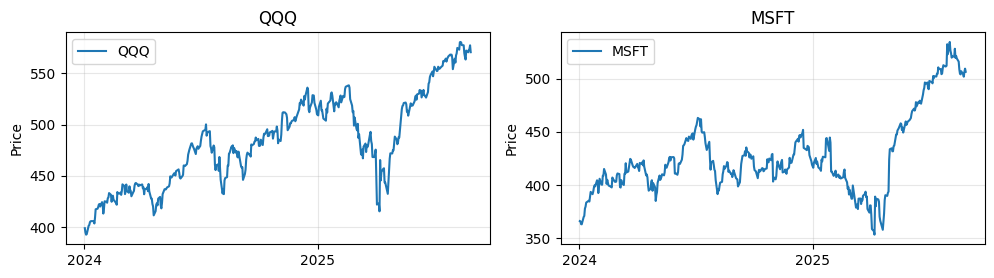


--- Data Fetching, Storing, and Plotting Complete ---


In [5]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json # Explicitly import json
import os # Import os to manage directories

# -------------------------------------------------------------
# Portfolio Configuration
# (Combines content from your previous Cell 2 and Cell 3)
# -------------------------------------------------------------
API_KEY = "1VWXIAX2LM6F6WV0" # Your Alpha Vantage API key
START_YEAR = 2024            # Filter data from this year onwards

TICKERS = [ "QQQ" , "MSFT"
    # Nasdaq Top 20 (US Equities - Large Cap)
    # "NVDA", "MSFT", "AAPL", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "TSM", "INTC",
    # "ADBE", "CMCSA", "CSCO", "PEP", "TXN", "PYPL", "QCOM", "AMGN", "GILD", "CHTR",

    # # Europe Top (European Equities - Broad/Large Cap)
    # "SAP", "ASML", "MC.PA", "RMS.PA", "OR.PA", "AZN", "VGK",

    # # Asia/Global Diversifiers (Asian Equities & Resources)
    # "XOM", "TSM", "TCEHY", "FXI", "EWY",

    # Crypto (from Alpha Vantage, use SYMBOL-USD format)
    # "BTC-USD", "ETH-USD"
]

# -------------------------------------------------------------
# Robust Data Fetching Function
# (Content from your previous working fetch_alpha_vantage_data_robust function)
# -------------------------------------------------------------
def fetch_alpha_vantage_data_robust(ticker: str, api_key: str, output_size: str = "full") -> pd.DataFrame | None:
    """
    Fetch daily OHLCV data from Alpha Vantage for a single ticker (adjusted for stocks).
    Handles both TIME_SERIES_DAILY_ADJUSTED for stocks and DIGITAL_CURRENCY_DAILY for crypto.
    """
    base_url = "https://www.alphavantage.co/query"
    df = None

    def print_common_msgs(j: dict, ticker: str) -> bool:
        """Prints common Alpha Vantage messages (Note, Error Message, etc.) and indicates if it's a failure."""
        is_failure = False
        for k in ("Note", "Error Message", "Information", "Message"):
            if k in j:
                print(f"{ticker}: {k}: {j[k]}")
                if k in ("Error Message", "Information", "Message") or "frequency" in j[k].lower():
                    is_failure = True
        return is_failure

    # Crypto data
    if ticker.endswith("-USD"):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": ticker.split("-")[0],
            "market": "USD",
            "apikey": api_key,
        }
        try:
            r = requests.get(base_url, params=params, timeout=20)
            r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            j = r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {ticker}: {e}")
            return None
        except json.JSONDecodeError:
            print(f"{ticker}: Response not JSON: {r.text[:200]}")
            return None

        if print_common_msgs(j, ticker):
            return None

        key = "Time Series (Digital Currency Daily)"
        if key not in j:
            print(f"{ticker}: missing '{key}' in response for crypto")
            return None

        ts = j[key]
        df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
        df.index = pd.to_datetime(df.index)

        # Crypto close column is '4. close' based on your diagnostic
        close_col = "4. close"

        if close_col not in df.columns:
            print(f"{ticker}: close column not found in crypto payload. Available: {df.columns.tolist()}")
            return None

        df = df.rename(columns={close_col: "Close"})
        df = df[["Close", "1. open", "2. high", "3. low"]].sort_index() # Include Open, High, Low
        df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low"}) # Rename for consistency
        df["Ticker"] = ticker
        return df

    # Stock data (adjusted for splits)
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": ticker,
        "outputsize": output_size,
        "apikey": api_key,
    }
    try:
        r = requests.get(base_url, params=params, timeout=20)
        r.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        j = r.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {ticker}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"{ticker}: Response not JSON: {r.text[:200]}")
        return None

    if print_common_msgs(j, ticker):
        return None

    # Accept either "Time Series (Daily Adjusted)" or "Time Series (Daily)" keys
    key = None
    if "Time Series (Daily Adjusted)" in j:
        key = "Time Series (Daily Adjusted)"
    elif "Time Series (Daily)" in j:
        key = "Time Series (Daily)"

    if key is None:
        print(f"{ticker}: no daily time series key present in response")
        return None

    ts = j[key]
    df = pd.DataFrame.from_dict(ts, orient="index").astype(float)
    df.index = pd.to_datetime(df.index)

    # Prefer adjusted close when available, else fallback to raw close
    close_col = None
    if "5. adjusted close" in df.columns:
        close_col = "5. adjusted close"
    elif "4. close" in df.columns:
        close_col = "4. close"

    if close_col is None:
        print(f"{ticker}: no close column found (expected '5. adjusted close' or '4. close'). Available: {df.columns.tolist()}")
        return None

    # Include '1. open', '2. high', '3. low' for stocks
    df = df.rename(columns={
        close_col: "Close",
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "6. volume": "Volume" # Include volume as well
    })
    # Select desired columns and ensure correct order
    df = df[["Open", "High", "Low", "Close", "Volume"]].sort_index()
    df["Ticker"] = ticker
    return df

# -------------------------------------------------------------
# Main Data Fetching and Storing Workflow
# -------------------------------------------------------------
print("\n--- Fetching and Storing Full Portfolio Data ---")
# Create a directory to store individual ticker data if it doesn't exist
output_dir = "ticker_data_parquet"
os.makedirs(output_dir, exist_ok=True)

fetched_tickers = []

for ticker in TICKERS:
    print(f"Fetching {ticker} (full history)...")
    # Using the robust fetcher with output_size='full'
    df = fetch_alpha_vantage_data_robust(ticker, API_KEY, output_size="full")

    if df is not None:
        # Filter from START_YEAR
        df = df[df.index.year >= START_YEAR]

        # Save individual ticker data to a parquet file
        file_path = os.path.join(output_dir, f"{ticker}.parquet")
        df.to_parquet(file_path)
        print(f"Successfully fetched and saved {len(df)} records for {ticker} to {file_path}")
        fetched_tickers.append(ticker)

        # Explicitly delete the DataFrame to free up memory
        del df

    time.sleep(12) # Respect Alpha Vantage API limit (5 requests/minute)

if not fetched_tickers:
    raise RuntimeError("No data was fetched for any ticker from Alpha Vantage. Please check API key, internet connection, or ticker symbols.")

print("\n✅ All available data fetched and stored as individual parquet files successfully!")
print(f"Fetched tickers: {fetched_tickers}")

# Note: The combined 'data' DataFrame is no longer created directly in memory.
# You will need to load data for analysis from the individual parquet files.

# -------------------------------------------------------------
# Plotting - Individual Ticker Performance (small multiples)
# (Modified to load data from parquet files)
# -------------------------------------------------------------
print("\n--- Plotting Individual Ticker Performance (from parquet) ---")
tickers_to_plot = fetched_tickers # Plot only the tickers for which data was fetched
n_plots = len(tickers_to_plot)

if n_plots > 0:
    # Determine grid size for subplots
    n_cols = 3 # You can adjust this for wider or narrower grids
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig_multiples, axes_multiples = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True)
    axes_multiples = axes_multiples.flatten() # Flatten for easy iteration

    for i, ticker in enumerate(tickers_to_plot):
        ax = axes_multiples[i]
        file_path = os.path.join(output_dir, f"{ticker}.parquet")

        try:
            # Load data for the individual ticker from its parquet file
            ticker_data = pd.read_parquet(file_path)

            # Ensure unique index by grouping on Date if duplicates exist (shouldn't if data is clean)
            if not ticker_data.index.is_unique:
                ticker_data = ticker_data.groupby(ticker_data.index).mean(numeric_only=True)

            # Plot closing price, ensuring 'Close' column exists
            if 'Close' in ticker_data.columns:
                ax.plot(ticker_data.index, ticker_data['Close'], label=ticker, linewidth=1.5)
            else:
                print(f"⚠️ Warning: 'Close' column not found in parquet for {ticker}. Skipping individual plot.")
                continue

            # Formatting
            ax.set_title(ticker)
            ax.set_ylabel('Price')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left')

        except FileNotFoundError:
            print(f"⚠️ Warning: Parquet file not found for {ticker}. Skipping individual plot.")
            continue

    # Set common X-axis locators/formatters only on the bottom row for clarity
    for ax_row in axes_multiples.reshape(n_rows, n_cols)[-1]:
        ax_row.xaxis.set_major_locator(mdates.YearLocator())
        ax_row.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide any unused subplots
    for j in range(i + 1, len(axes_multiples)):
        fig_multiples.delaxes(axes_multiples[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()
else:
    print("No tickers to plot.")


print("\n--- Data Fetching, Storing, and Plotting Complete ---")

In [6]:
# In the previous cell, data is now saved as individual parquet files per ticker.
# Load individual ticker data and combine them into a single DataFrame.

all_data_frames = []
output_dir = "ticker_data_parquet"

# Iterate through the fetched tickers and load their parquet files
for ticker in fetched_tickers:
    file_path = os.path.join(output_dir, f"{ticker}.parquet")
    try:
        ticker_df = pd.read_parquet(file_path)
        all_data_frames.append(ticker_df)
    except FileNotFoundError:
        print(f"Warning: Parquet file not found for {ticker}. Skipping.")
        continue

if all_data_frames:
    # Combine all individual DataFrames into a single one
    data = pd.concat(all_data_frames)

    # Save the combined data to a Parquet file
    data.to_parquet("portfolio_data.parquet")
    print("Combined data saved to portfolio_data.parquet")

    # Load the data from the Parquet file to verify
    loaded_data = pd.read_parquet("portfolio_data.parquet")

    # Reorder columns to have 'Ticker' as the first column
    cols = ['Ticker'] + [col for col in loaded_data.columns if col != 'Ticker']
    loaded_data = loaded_data[cols]

    # Display the first few rows of the loaded data
    display(loaded_data.head())

else:
    print("No data frames were loaded to combine.")

Combined data saved to portfolio_data.parquet


,Ticker,Open,High,Low,Close,Volume
2024-01-02,QQQ,405.84,406.09,400.2400,399.190687,58026946.0
2024-01-03,QQQ,399.93,401.00,397.8900,394.966656,47002803.0
2024-01-04,QQQ,396.44,399.59,396.0600,392.933966,39432797.0
2024-01-05,QQQ,396.45,399.56,395.3400,393.399997,44742783.0
2024-01-08,QQQ,397.99,405.24,397.8399,401.530760,42473796.0


vectors, parquets, dask,

van hier uit, gewoon stap per stap de oude notebook opnieuw overnemen, het zou goed moeten kunnen, gewoon, ombouwen pretty much, logica dieper pakken, meteen op schaal gaan, meer documenteren, robustness test inbouwen etc. meteen

train / test data split voor in and out of sample,

rolling sharpe etc.

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y). Assuming 'Close' is the target.
# You might need to adjust features based on your model's needs.
X = loaded_data.drop(columns=['Close', 'Ticker']) # Example: dropping 'Close' and 'Ticker' as features
y = loaded_data['Close']
tickers = loaded_data['Ticker'] # Keep track of tickers

# Split the data while maintaining the time series order.
# We will use the index (Date) to split the data.
# The split point will be 80% of the way through the sorted index.

# Sort the data by index (Date) to ensure proper time series splitting
loaded_data_sorted = loaded_data.sort_index()


# Calculate the split point index
split_index = int(len(loaded_data_sorted) * 0.8)


# Split the data based on the calculated index
train_data = loaded_data_sorted.iloc[:split_index]
test_data = loaded_data_sorted.iloc[split_index:]

print("Data split into training and testing sets.")
print(f"Training set shape: {train_data.shape}")
print(f"Testing set shape: {test_data.shape}")

display(train_data.head())
display(test_data.head())

Data split into training and testing sets.
Training set shape: (667, 6)
Testing set shape: (167, 6)


,Ticker,Open,High,Low,Close,Volume
2024-01-02,QQQ,405.84,406.0900,400.240,399.190687,58026946.0
2024-01-02,MSFT,373.86,375.9000,366.771,366.132475,25258633.0
2024-01-03,QQQ,399.93,401.0000,397.890,394.966656,47002803.0
2024-01-03,MSFT,369.01,373.2562,368.510,365.865924,23083465.0
2024-01-04,QQQ,396.44,399.5900,396.060,392.933966,39432797.0


,Ticker,Open,High,Low,Close,Volume
2025-05-01,MSFT,431.11,436.99,424.900,423.924421,58938100.0
2025-05-02,MSFT,431.74,439.44,429.985,433.770150,30757434.0
2025-05-02,QQQ,486.54,490.91,484.830,488.287103,39218082.0
2025-05-05,QQQ,484.60,489.03,484.100,485.390323,28309490.0
2025-05-05,MSFT,432.87,439.50,432.110,434.657063,20136053.0


In [8]:
# --- Parameter Grid (Expanded Ranges) ---
from itertools import product

KAMA_ER_WINDOW_RANGE = [10, 15, 20, 25, 30]
KAMA_FAST_PAIR_RANGE = [(2, 10), (3, 10), (4, 10)]
KAMA_MED_PAIR_RANGE = [(5, 15), (6, 15), (7, 15)]
KAMA_SLOW_PAIR_RANGE = [(10, 20), (12, 20), (14, 20)]
ST_ATR_PERIOD_RANGE = [7, 14, 21, 28]
ST_MULTIPLIER_RANGE = [2.0, 3.0, 4.0, 5.0]
OBV_VWMA_LEN_RANGE = [10, 20, 30, 40, 50]

ALL_PARAM_COMBINATIONS = []
for er, fp, mp, sp, ap, mul, vw in product(
    KAMA_ER_WINDOW_RANGE,
    KAMA_FAST_PAIR_RANGE,
    KAMA_MED_PAIR_RANGE,
    KAMA_SLOW_PAIR_RANGE,
    ST_ATR_PERIOD_RANGE,
    ST_MULTIPLIER_RANGE,
    OBV_VWMA_LEN_RANGE,
):
    ALL_PARAM_COMBINATIONS.append({
        'kama_er_window': er,
        'kama_fast_pair': fp,
        'kama_medium_pair': mp,
        'kama_slow_pair': sp,
        'st_atr_period': ap,
        'st_multiplier': mul,
        'obv_vwma_len': vw,
    })

print(f"Total parameter combinations: {len(ALL_PARAM_COMBINATIONS)}")

Total parameter combinations: 10800


In [9]:
# --- manual indicators ---

def rma(series: pd.Series, length: int) -> pd.Series:
    length = max(1, int(length))
    alpha = 1.0 / length
    r = series.copy().astype(float)
    r.iloc[0] = series.iloc[:length].mean() if len(series) >= length else series.iloc[0]
    for i in range(1, len(series)):
        r.iloc[i] = alpha * series.iloc[i] + (1 - alpha) * r.iloc[i - 1]
    return r


def compute_kama(price: pd.Series, er_window: int, fast_period: int, fast_slow: int) -> pd.Series:
    er_window = max(1, int(er_window))
    fast_period = max(1, int(fast_period))
    fast_slow = max(2, int(fast_slow))

    change = price.diff(er_window).abs()
    volatility = price.diff().abs().rolling(er_window).sum()
    efficiency_ratio = np.divide(change, volatility, out=np.zeros_like(change), where=volatility != 0)

    sc = (2.0 / (fast_period + 1.0)) * (fast_slow - efficiency_ratio)
    sc = sc.clip(lower=2.0 / (fast_period + 1.0), upper=2.0 / (fast_slow + 1.0))
    kama = price.copy().astype(float)
    kama.iloc[:er_window] = price.iloc[:er_window]
    for i in range(er_window, len(price)):
        kama.iloc[i] = kama.iloc[i - 1] + sc.iloc[i] * (price.iloc[i] - kama.iloc[i - 1])
    return kama


def supertrend_on_df(df: pd.DataFrame, atr_period: int, multiplier: float) -> pd.DataFrame:
    high = df['High'].astype(float)
    low = df['Low'].astype(float)
    close = df['Close'].astype(float)

    tr = pd.concat([
        (high - low),
        (high - close.shift(1)).abs(),
        (low - close.shift(1)).abs()
    ], axis=1).max(axis=1)
    atr = rma(tr, atr_period)

    hl2 = (high + low) / 2.0
    upper = hl2 + multiplier * atr
    lower = hl2 - multiplier * atr

    final_upper = upper.copy()
    final_lower = lower.copy()
    for i in range(1, len(df)):
        if close.iloc[i-1] > final_upper.iloc[i-1]:
            final_upper.iloc[i] = min(upper.iloc[i], final_upper.iloc[i-1])
        else:
            final_upper.iloc[i] = upper.iloc[i]
        if close.iloc[i-1] < final_lower.iloc[i-1]:
            final_lower.iloc[i] = max(lower.iloc[i], final_lower.iloc[i-1])
        else:
            final_lower.iloc[i] = lower.iloc[i]

    st = final_upper.copy()
    direction = pd.Series(index=df.index, dtype=int)
    direction.iloc[0] = 1
    for i in range(1, len(df)):
        if (st.iloc[i-1] == final_upper.iloc[i-1]) and (close.iloc[i] <= final_upper.iloc[i]):
            st.iloc[i] = final_upper.iloc[i]
            direction.iloc[i] = -1
        elif (st.iloc[i-1] == final_upper.iloc[i-1]) and (close.iloc[i] > final_upper.iloc[i]):
            st.iloc[i] = final_lower.iloc[i]
            direction.iloc[i] = 1
        elif (st.iloc[i-1] == final_lower.iloc[i-1]) and (close.iloc[i] >= final_lower.iloc[i]):
            st.iloc[i] = final_lower.iloc[i]
            direction.iloc[i] = 1
        else:
            st.iloc[i] = final_upper.iloc[i]
            direction.iloc[i] = -1

    return pd.DataFrame({'ST': st, 'ST_dir': direction})

def compute_indicators_for_group(df: pd.DataFrame,
                                 kama_er_window: int,
                                 fast_pair: tuple,
                                 med_pair: tuple,
                                 slow_pair: tuple,
                                 st_atr_period: int,
                                 st_multiplier: float,
                                 obv_vwma_len: int) -> pd.DataFrame:
    d = df.sort_index().copy()

    # KAMAs
    d['KAMA_fast'] = compute_kama(d['Close'], kama_er_window, fast_pair[0], fast_pair[1])
    d['KAMA_medium'] = compute_kama(d['Close'], kama_er_window, med_pair[0], med_pair[1])
    d['KAMA_slow'] = compute_kama(d['Close'], kama_er_window, slow_pair[0], slow_pair[1])

    # SuperTrend
    st_df = supertrend_on_df(d, st_atr_period, st_multiplier)
    d['ST'] = st_df['ST']
    d['ST_dir'] = st_df['ST_dir']

    # OBV
    obv = np.where(d['Close'] > d['Close'].shift(1), d['Volume'],
                   np.where(d['Close'] < d['Close'].shift(1), -d['Volume'], 0))
    d['OBV'] = pd.Series(obv, index=d.index).cumsum().fillna(0)

    # VWMA of OBV
    vol_roll = d['Volume'].rolling(obv_vwma_len).sum()
    obv_vol_roll = (d['OBV'] * d['Volume']).rolling(obv_vwma_len).sum()
    d['OBV_VWMA'] = obv_vol_roll / vol_roll

    return d


In [ ]:
# 🚀 TRUE MULTI-CORE: Dask Distributed — simple event-based signals (±1 on cross, else 0)
import psutil
import gc
import time
from pathlib import Path

from dask.distributed import Client, LocalCluster, as_completed

import pandas as pd
import numpy as np

# Storage (align with your viewer)
signals_root = Path("discrete algos (optimized per)") / "signals"
signals_root.mkdir(parents=True, exist_ok=True)

# Start a local Dask cluster (process-based, 1 thread per worker)
num_workers = max(1, psutil.cpu_count(logical=False) or 4)
cluster = LocalCluster(
    n_workers=num_workers,
    threads_per_worker=1,
    processes=True,
    dashboard_address=None,
    memory_limit="auto",
)
client = Client(cluster)
print(f"Dask cluster started with {num_workers} workers")

def cross_up(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a > b) & (a.shift(1) <= b.shift(1))

def cross_down(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a < b) & (a.shift(1) >= b.shift(1))

def compute_signals_with_params(df: pd.DataFrame, params: dict) -> pd.DataFrame:
    try:
        if df.empty:
            return pd.DataFrame()

        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
        if any(c not in df.columns for c in required_cols):
            return pd.DataFrame()

        ticker_value = df['Ticker'].iloc[0]

        p = params
        kama_er_window = int(p['kama_er_window'])

        if 'kama_fast_pair' in p:
            fast_pair = tuple(map(int, p['kama_fast_pair']))
            med_pair  = tuple(map(int, p['kama_medium_pair']))
            slow_pair = tuple(map(int, p['kama_slow_pair']))
        else:
            fast_pair = (int(p['kama_fast_period']), int(p['kama_fast_slow']))
            med_pair  = (int(p['kama_medium_period']), int(p['kama_medium_slow']))
            slow_pair = (int(p['kama_slow_period']), int(p['kama_slow_slow']))

        st_atr_period = int(p['st_atr_period'])
        st_multiplier = float(p['st_multiplier'])
        obv_vwma_len = int(p['obv_vwma_len'])

        out = compute_indicators_for_group(
            df.copy(),
            kama_er_window,
            fast_pair,
            med_pair,
            slow_pair,
            st_atr_period,
            st_multiplier,
            obv_vwma_len
        )

        if 'Ticker' not in out.columns:
            out['Ticker'] = ticker_value

        # === SIMPLE EVENT-BASED SIGNALS (±1 on the crossing bar, else 0) ===

        # SuperTrend: price vs ST line
        up_st = (out['Close'] > out['ST']) & (out['Close'].shift(1) <= out['ST'].shift(1))
        dn_st = (out['Close'] < out['ST']) & (out['Close'].shift(1) >= out['ST'].shift(1))
        out['Buy_SuperTrend'] = 0
        out.loc[up_st, 'Buy_SuperTrend'] = 1
        out.loc[dn_st, 'Buy_SuperTrend'] = -1

        # KAMA: fast vs slow (use fast/slow for clarity)
        up_k = (out['KAMA_fast'] > out['KAMA_slow']) & (out['KAMA_fast'].shift(1) <= out['KAMA_slow'].shift(1))
        dn_k = (out['KAMA_fast'] < out['KAMA_slow']) & (out['KAMA_fast'].shift(1) >= out['KAMA_slow'].shift(1))
        out['Buy_KAMA_Cross'] = 0
        out.loc[up_k, 'Buy_KAMA_Cross'] = 1
        out.loc[dn_k, 'Buy_KAMA_Cross'] = -1

        # OBV vs VWMA: simple cross (add epsilon if jitter)
        up_o = (out['OBV'] > out['OBV_VWMA']) & (out['OBV'].shift(1) <= out['OBV_VWMA'].shift(1))
        dn_o = (out['OBV'] < out['OBV_VWMA']) & (out['OBV'].shift(1) >= out['OBV_VWMA'].shift(1))
        out['Buy_OBV_VWMA_Cross'] = 0
        out.loc[up_o, 'Buy_OBV_VWMA_Cross'] = 1
        out.loc[dn_o, 'Buy_OBV_VWMA_Cross'] = -1

        # Cast to int
        out['Buy_SuperTrend'] = out['Buy_SuperTrend'].astype(int)
        out['Buy_KAMA_Cross'] = out['Buy_KAMA_Cross'].astype(int)
        out['Buy_OBV_VWMA_Cross'] = out['Buy_OBV_VWMA_Cross'].astype(int)

        # Attach parameter metadata
        param_cols = {
            'kama_er_window': kama_er_window,
            'kama_fast_period': fast_pair[0],
            'kama_fast_slow': fast_pair[1],
            'kama_medium_period': med_pair[0],
            'kama_medium_slow': med_pair[1],
            'kama_slow_period': slow_pair[0],
            'kama_slow_slow': slow_pair[1],
            'st_atr_period': st_atr_period,
            'st_multiplier': st_multiplier,
            'obv_vwma_len': obv_vwma_len,
        }
        for k, v in param_cols.items():
            out[k] = v

        cols_keep = [
            'Open','High','Low','Close','Volume','Ticker',
            'KAMA_fast','KAMA_medium','KAMA_slow','ST',
            'OBV','OBV_VWMA',
            'Buy_KAMA_Cross','Buy_OBV_VWMA_Cross','Buy_SuperTrend'
        ] + list(param_cols.keys())

        return out[[c for c in cols_keep if c in out.columns]]
    except Exception:
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

def compute_signals_parallel_dask(ticker: str, train_df: pd.DataFrame, param_combos: list, batch_size: int = 500):
    print(f"\n🚀 Processing {ticker}")
    print(f"📊 Combinations: {len(param_combos)} | Batch size: {batch_size}")

    # Scatter train_df to workers once (broadcast, zero-copy reference per task)
    df_future = client.scatter(train_df, broadcast=True)

    ticker_dir = signals_root / ticker
    ticker_dir.mkdir(parents=True, exist_ok=True)

    batches = [param_combos[i:i + batch_size] for i in range(0, len(param_combos), batch_size)]
    total_processed = 0

    print(f"📦 Processing {len(batches)} batches with {num_workers} workers...")

    for batch_idx, batch_params in enumerate(batches, 1):
        start = time.time()
        futures = [client.submit(compute_signals_with_params, df_future, params, pure=False)
                   for params in batch_params]

        batch_results = []
        for fut in as_completed(futures):
            res = fut.result()
            if isinstance(res, pd.DataFrame) and not res.empty:
                batch_results.append(res)

        if batch_results:
            combined = pd.concat(batch_results).sort_index()
            batch_file = ticker_dir / f"signals_batch_{batch_idx:03d}.parquet"
            combined.to_parquet(batch_file, compression="snappy")

            rows = len(combined)
            total_processed += rows
            dur = max(1e-6, time.time() - start)
            print(f"💾 Saved {batch_file.name} | 📈 Rows: {rows} | ⏱️ {dur:.1f}s | 🚀 {rows/dur:.0f} rows/s")

            del combined, batch_results
            gc.collect()
        else:
            print(f"⚠️ Batch {batch_idx} produced 0 rows.")

    print(f"\n✅ Completed {ticker}: {total_processed} total rows")
    return total_processed

# ==== MAIN EXECUTION ====
assert 'train_data' in globals(), "Run train/test split first!"
assert 'ALL_PARAM_COMBINATIONS' in globals(), "Run parameter generation first!"

start_time = time.time()
active_tickers = TICKERS if ('TICKERS' in globals() and TICKERS) else sorted(train_data['Ticker'].unique().tolist())

print("🎯 STARTING TRUE PARALLEL GRID SEARCH (Dask Distributed)")
print(f"📊 Tickers: {active_tickers}")
print(f"🔢 Total combinations: {len(ALL_PARAM_COMBINATIONS)}")
print(f"💻 Physical CPU Cores: {psutil.cpu_count(logical=False)}")

total_rows_all_tickers = 0
for ticker in active_tickers:
    df_train_ticker = train_data[train_data['Ticker'] == ticker]
    if df_train_ticker.empty:
        print(f"⚠️ No training data for {ticker}; skipping.")
        continue

    # Optional quick diagnostics
    print(f"\n🔍 DataFrame check for {ticker}:")
    print(f"   Shape: {df_train_ticker.shape}")
    print(f"   Columns: {list(df_train_ticker.columns)}")
    if 'Ticker' in df_train_ticker.columns:
        print(f"   Unique tickers: {df_train_ticker['Ticker'].unique()}")

    ticker_rows = compute_signals_parallel_dask(
        ticker=ticker,
        train_df=df_train_ticker,
        param_combos=ALL_PARAM_COMBINATIONS,
        batch_size=500
    )
    total_rows_all_tickers += ticker_rows

total_time = time.time() - start_time
print("\n🎉 ALL COMPUTATIONS COMPLETE!")
print(f"⏱️ Total time: {total_time:.1f} seconds")
print(f"📊 Total rows processed: {total_rows_all_tickers:,}")
if total_time > 0:
    print(f"🚀 Average speed: {total_rows_all_tickers/total_time:.0f} rows/second")
print("💾 Output:", signals_root)

Dask cluster started with 10 workers
🎯 STARTING TRUE PARALLEL GRID SEARCH (Dask Distributed)
📊 Tickers: ['QQQ', 'MSFT']
🔢 Total combinations: 10800
💻 Physical CPU Cores: 10

🔍 DataFrame check for QQQ:
   Shape: (334, 6)
   Columns: ['Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
   Unique tickers: ['QQQ']

🚀 Processing QQQ
📊 Combinations: 10800 | Batch size: 500
📦 Processing 22 batches with 10 workers...
💾 Saved signals_batch_001.parquet | 📈 Rows: 167000 | ⏱️ 12.4s | 🚀 13471 rows/s
💾 Saved signals_batch_002.parquet | 📈 Rows: 167000 | ⏱️ 10.7s | 🚀 15556 rows/s
💾 Saved signals_batch_003.parquet | 📈 Rows: 167000 | ⏱️ 10.8s | 🚀 15524 rows/s
💾 Saved signals_batch_004.parquet | 📈 Rows: 167000 | ⏱️ 11.1s | 🚀 15072 rows/s
💾 Saved signals_batch_005.parquet | 📈 Rows: 167000 | ⏱️ 10.8s | 🚀 15471 rows/s
💾 Saved signals_batch_006.parquet | 📈 Rows: 167000 | ⏱️ 10.7s | 🚀 15639 rows/s
💾 Saved signals_batch_007.parquet | 📈 Rows: 167000 | ⏱️ 10.8s | 🚀 15508 rows/s
💾 Saved signals_batch_008.parquet 

In [ ]:
# Check parquet file creation and columns (absolute path)
import pandas as pd
from pathlib import Path

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Use absolute path to signals directory
signals_root = Path("/Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)/signals")

# Example: check the first batch for QQQ (adjust ticker if needed)
ticker = "QQQ"
signals_dir = signals_root / ticker
if signals_dir.exists():
    batch_files = list(signals_dir.glob("signals_batch_*.parquet"))
    if batch_files:
        sample_file = batch_files[0]  # First batch
        print(f"Reading sample file: {sample_file}")
        df = pd.read_parquet(sample_file)
        print(f"Shape: {df.shape}")
        print("Columns:", list(df.columns))
        print("\nFirst 100 rows:")
        print(df.head(600).to_string())
        print("\nLast 50 rows:")
        print(df.tail(50).to_string())
        
        # Check signal columns
        signal_cols = ['Buy_KAMA_Cross', 'Buy_OBV_VWMA_Cross', 'Buy_SuperTrend']
        for col in signal_cols:
            if col in df.columns:
                print(f"\n{col} value counts:")
                print(df[col].value_counts())
    else:
        print(f"No batch files found in {signals_dir}")
else:
    print(f"Signals directory not found: {signals_dir}")
    print("Available directories:", list(signals_root.iterdir()) if signals_root.exists() else "signals_root not found")

Reading sample file: /Users/chielg/Documents/GitHub/yourquant/discrete algos (optimized per)/signals/QQQ/signals_batch_014.parquet
Shape: (770500, 26)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'KAMA_fast', 'KAMA_medium', 'KAMA_slow', 'ST', 'ST_dir', 'OBV', 'OBV_VWMA', 'Buy_KAMA_Cross', 'Buy_OBV_VWMA_Cross', 'Buy_SuperTrend', 'kama_er_window', 'kama_fast_period', 'kama_fast_slow', 'kama_medium_period', 'kama_medium_slow', 'kama_slow_period', 'kama_slow_slow', 'st_atr_period', 'st_multiplier', 'obv_vwma_len']

First 100 rows:
              Open    High     Low       Close      Volume Ticker   KAMA_fast  KAMA_medium   KAMA_slow          ST  ST_dir         OBV  OBV_VWMA  Buy_KAMA_Cross  Buy_OBV_VWMA_Cross  Buy_SuperTrend  kama_er_window  kama_fast_period  kama_fast_slow  kama_medium_period  kama_medium_slow  kama_slow_period  kama_slow_slow  st_atr_period  st_multiplier  obv_vwma_len
2018-01-02  156.56  158.53  156.17  150.564200  32573272.0    QQQ  150.564200   150.564